# NLP (Natural Language Processing) com Python

Esta é uma visão geral do processamento de linguagem natural, que basicamente consiste em combinar técnicas de Machine Learning com texto e usando matemática e estatísticas para obter esse texto em um formato que os algoritmos de aprendizado de máquina possam entender!
    
** Requisitos: você precisará ter NLTK instalado, além de baixar o corpus para palavras-passe. Para baixar tudo com uma instalação conda, execute a célula abaixo com as duas primeiras linhas descomentadas. **

In [24]:
#!conda install nltk
#nltk.download()
import nltk

file = '/repos/me/meriat-ml-notes/src/data/sms-spam/SMSSpamCollection'

## Obtendo os dados

Usaremos um conjunto de dados da [UCI](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! Faça o download no link.

O arquivo que estamos usando contém uma coleção de mais de 5 mil mensagens SMS. Você pode checar o arquivo ** readme ** para obter mais informações.

Vamos continuar usando **rstrip()** e uma lista de compreensão para obter uma lista de todas as linhas de mensagens de texto:

In [25]:
messages = [line.rstrip() for line in open(file)]
print(len(messages))

5574


Uma coleção de textos também é chamado às vezes de "corpus". Vamos imprimir as dez primeiras mensagens e numerá-las usando ** enumerate **:

In [26]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code 

Devido ao espaçamento, podemos dizer que este é um arquivo [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("valores separados por tabulação"), onde a primeira coluna é uma etiqueta dizendo se a a mensagem dada é uma mensagem normal (comumente conhecida como "ham") ou "spam". A segunda coluna é a própria mensagem. (Notemos que nossos números não fazem parte do arquivo, eles são apenas do ** enumerate **).

Usando estes exemplos de ham e spam rotulados, iremos treinar um modelo de aprendizado de máquina para aprender a discriminar entre ham / spam automaticamente **. Então, com um modelo treinado, poderemos ** classificar mensagens arbitrárias sem letras ** como ham ou spam.

A partir da documentação oficial SciKit Learn, podemos visualizar nosso processo:

<img src='http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/_images/plot_ML_flow_chart_3.png' width=600/>

Em vez de analisar TSV manualmente usando o Python, podemos aproveitar os pandas! Vamos continuar e importá-lo!

In [27]:
import pandas as pd

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

Usaremos ** read_csv ** e ajustaremos o argumento** sep **. Também podemos especificar os nomes das colunas desejadas passando em uma lista de * nomes *.

In [29]:
messages = pd.read_csv(file, sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Análise de dados exploratória

Vamos verificar algumas das estatísticas com plots e os métodos incorporados ao pandas!

In [30]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Vamos usar ** groupby ** e usar describe() nos rótulos, desta forma podemos começar a pensar sobre os recursos que separam ham e spam!

In [31]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Ao continuar nossa análise, queremos começar a pensar nos parâmetrs que usaremos. Isso acompanha a idéia geral de [engenharia de parâmetros](https://en.wikipedia.org/wiki/Feature_engineering). A engenharia de recursos é uma parte muito grande da detecção de spam em geral. Encorajo você a ler sobre o assunto!

Vamos criar uma nova coluna para detectar o tamanho das mensagens de texto:

In [32]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Visualização de dados
Vamos visualizar isso! Vamos fazer as importações:

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

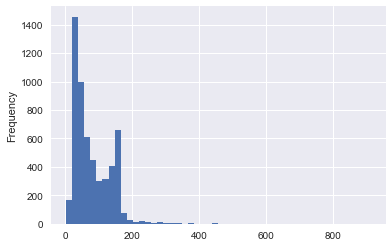

In [34]:
messages['length'].plot(bins=50, kind='hist') 

Jogue com o tamanho da variável bin! Parece que o comprimento do texto pode ser uma boa característica para pensar! Vamos tentar explicar também o por que do eixo x ir até o comprimento 1000. Isso deve significar que há uma mensagem muito longa!

In [35]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

910 caracteres! Vamos usar o mascaramento para encontrar esta mensagem:

In [36]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Parece que temos algum tipo de texto enviado por um Romeu! Mas vamos nos concentrar na idéia de tentar ver se o comprimento da mensagem é uma característica distintiva entre ham e spam:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x115a274a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x115c487f0>], dtype=object)

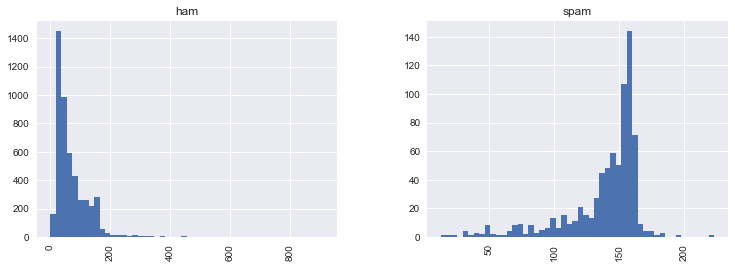

In [37]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Muito interessante! Com apenas EDA básica, conseguimos descobrir uma tendência de que as mensagens de spam tendem a ter mais caracteres. (Desculpe, Romeu!)

Agora vamos começar a processar os dados para que possamos eventualmente usá-lo com o SciKit Learn!

## Pré Processamento de texto

Nosso principal problema com nossos dados é que está tudo em formato de texto (strings). Os algoritmos de classificação que aprendemos até agora precisam de algum tipo de vetor de características numéricas para realizar a tarefa de classificação. Na verdade, existem muitos métodos para converter um textos em um formato vetorial. O mais simples é a abordagem [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model), onde cada palavra única em um texto será representada por um número.


Nesta seção, converteremos as mensagens brutas (seqüência de caracteres) em vetores (seqüências de números).

Como primeiro passo, vamos escrever uma função que dividirá uma mensagem em suas palavras individuais e retornará uma lista. Também removeremos palavras muito comuns, ('' '', 'a', etc.). Para fazer isso, iremos aproveitar a biblioteca NLTK. É praticamente a biblioteca padrão em Python para processar texto e tem muitos recursos úteis. Nós só usaremos alguns dos básicos aqui.

Vamos criar uma função que processará a string na coluna da mensagem, então podemos usar ** apply() ** do pandas para processar todo o texto no DataFrame.

Primeira eliminamos a pontuação. Podemos aproveitar a biblioteca incorporada ** string ** do Python para obter uma lista rápida de todas as possíveis pontuações:

In [38]:
import string

mess = 'Sample message! Notice: it has punctuation.'

# Checa para retirar pontuações
nopunc = [char for char in mess if char not in string.punctuation]

# Junta novamente os caracteres para formar um string e não uma lista
nopunc = ''.join(nopunc)

Agora vamos ver como remover stopwords. Podemos importar uma lista de stopwords do inglesas da NLTK (verifique a documentação para mais idiomas e informações).

In [39]:
from nltk.corpus import stopwords
stopwords.words('english')[0:10] # Mostre alguns exemplos de stopwords

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [40]:
nopunc.split()

['Sample', 'message', 'Notice', 'it', 'has', 'punctuation']

In [41]:
# Agora remova as stopwords
clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [42]:
clean_mess

['Sample', 'message', 'Notice', 'punctuation']

Agora, coloquemos esses dois juntos em uma função para aplicá-lo ao nosso DataFrame mais tarde:

In [43]:
def text_process(mess):
    # Retira pontuações
    nopunc = [char for char in mess if char not in string.punctuation]

    # Junta-os para formar strings
    nopunc = ''.join(nopunc)
    
    # Remove as stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Aqui está o DataFrame original novamente:

In [44]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Agora vamos "tokenizar" essas mensagens. Tokenização é apenas o termo usado para descrever o processo de conversão das cadeias de texto normais em uma lista de tokens (palavras que realmente queremos).

Vamos ver um exemplo de saída na coluna:

**Nota:**
Podemos obter alguns avisos ou erros para símbolos que não contamos ou que não estavam no Unicode (como um símbolo de libra britânica)

In [45]:
# Verifique para ver se está funcionando
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [46]:
# Mostra o DataFrame original
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Continuação da normalização

Há muitas maneiras de continuar normalizando esse texto. Como [Stemming] (https://en.wikipedia.org/wiki/Stemming) ou distinguindo por [parte do discurso] (http://www.nltk.org/book/ch05.html).

O NLTK possui muitas ferramentas integradas e UMA excelente documentação em muitos destes métodos. Às vezes, eles não funcionam bem para mensagens de texto devido ao modo como muitas pessoas tendem a usar abreviaturas ou taquigrafia:
    
    
Alguns métodos de normalização de texto terão problemas com este tipo de taquigrafia e, portanto, deixarei você para explorar esses métodos mais avançados através do [NLTK book online](http://www.nltk.org/book/).

Por enquanto, apenas nos concentraremos EMs converter nossa lista de palavras para um vetor real que o SciKit-Learn pode usar.

## Vetorização

Agora temos as mensagens como listas de tokens (também conhecido como [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) e agora nós precisa converter cada uma dessas mensagens em um vetor com o qual os modelos de algoritmo do SciKit Learn podem funcionar.

Agora, converteremos cada mensagem, representada como uma lista de tokens (lemmas) acima, em um vetor que os modelos de aprendizagem de máquinas podem entender.

Vamos fazer isso em três etapas usando o modelo bag-of-words:

1. Contar quantas vezes ocorre uma palavra em cada mensagem (conhecida como freqüência de termo)

2. Pesar as contagens, de modo que tokens freqüentes recebem menor peso (freqüência inversa do documento)

3. Normalize os vetores para o comprimento da unidade, para abstrair do comprimento do texto original (norma L2)

Vamos começar o primeiro passo:

Cada vetor terá tantas dimensões quanto houverem palavras únicas no corpo do SMS. Em primeiro lugar usaremos o ** CountVectorizer ** do SciKit Learn **. Este modelo converterá uma coleção de documentos de texto em uma matriz de contagem de token.

Podemos imaginar isso como uma matriz bidimensional. Onde a dimensão 1 é o vocabulário inteiro (1 linha por palavra) e a outra dimensão são os documentos reais, neste caso uma coluna por mensagem de texto.

Por exemplo:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>

Uma vez que há tantas mensagens, podemos esperar muitos elementos zerados. Por isso, o SciKit Learn emitirá uma [Matriz Esparsa](https://en.wikipedia.org/wiki/Sparse_matrix).

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

Há muitos argumentos e parâmetros que podem ser passados para o CountVectorizer. Neste caso, vamos especificar o ** analyzer ** para ser nossa própria função previamente definida:

In [48]:
# Talvez demor um pouco
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

print(len(bow_transformer.vocabulary_))

11425


Vamos pegar uma mensagem de texto e obter suas contagens de bag-of-words como um vetor, colocando em uso o nosso novo `bow_transformer`:

In [49]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


Agora vejamos sua representação vetorial:

In [50]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


Isso significa que existem sete palavras únicas na mensagem número 4 (depois de remover stopwords). Dois deles aparecem duas vezes, o resto apenas uma vez. Vamos em frente e verifique e confirme quais aparecem duas vezes:

In [51]:
print(bow_transformer.get_feature_names()[4073])
print(bow_transformer.get_feature_names()[9570])

UIN
schedule


Agora, podemos usar **.transform ** em nosso objeto transformado Bag-of-Words (bow) e transformar todo o DataFrame de mensagens.

In [52]:
messages_bow = bow_transformer.transform(messages['message'])

In [53]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [54]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


Após a contagem, o termo ponderação e normalização pode ser feito com [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), usando o `TfidfTransformer` do scikit-learn.

____
### Então, o que é TF-IDF?
TF-IDF significa *term frequency-inverse document frequency* (frequência do termo - inverso da frequência nos documentos), e o peso tf-idf é um peso freqüentemente usado na recuperação de informações e na mineração de texto. Esse peso é uma medida estatística usada para avaliar a importância de uma palavra em um documento, coleção ou corpus. A importância aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento, mas é compensada pela freqüência da palavra no corpus. As variações do esquema de ponderação tf-idf são frequentemente utilizadas pelos motores de busca como uma ferramenta central na pontuação e classificação da relevância de um documento, dada uma consulta do usuário.

Uma das funções de classificação mais simples é calculada somando o tf-idf para cada termo de consulta; Muitas funções de classificação mais sofisticadas são variantes desse modelo simples.

Normalmente, o peso de tf-idf é composto por dois termos: o primeiro calcula a Freqüência do termo normalizada (TF), ou seja, o número de vezes que uma palavra aparece em um documento, dividido pelo número total de palavras nesse documento; O segundo termo é a Freqüência do Documento Inverso (IDF), calculado como o logaritmo do número de documentos no corpus dividido pela quantidade de documentos onde o termo específico aparece.

** TF: Frequência do termo **, que mede a frequência com que ocorre um termo em um documento. Uma vez que cada documento é diferente em comprimento, é possível que um termo apareça muito mais vezes em documentos longos do que os mais curtos. Assim, o termo freqüência é freqüentemente dividido pelo comprimento do documento (também conhecido como o número total de termos no documento) como forma de normalização:

* TF (t) = (Número de vezes que o termo t aparece em um documento) / (Número total de termos no documento). *

** IDF: Freqüência do Documento Inverso **, que mede o quão importante é um termo. Ao computar TF, todos os termos são considerados igualmente importantes. No entanto, é sabido que certos termos, como "is", "of", e "that", podem aparecer muitas vezes, mas têm pouca importância. Assim, precisamos pesar os termos freqüentes, enquanto aumentamos as raras, ao computar o seguinte:

* IDF (t) = log_e (Número total de documentos / Número de documentos com termo t nele). *

Veja abaixo um exemplo simples.

**Exemplo:**

Considere um documento contendo 100 palavras em que a palavra gato aparece 3 vezes.

O termo frequência (isto é, tf) para gato é então (3/100) = 0,03. Agora, suponha que temos 10 milhões de documentos e a palavra gato aparece em mil desses. Então, a frequência inversa do documento (isto é, idf) é calculada como log (10 000 000/1000) = 4. Assim, o peso Tf-idf é o produto dessas quantidades: 0,03 * 4 = 0,12.
____

Avançemos e vejamos como podemos fazer isso no SciKit Learn:

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.538562626293
  (0, 7186)	0.438936565338
  (0, 6222)	0.318721689295
  (0, 6204)	0.299537997237
  (0, 5261)	0.297299574059
  (0, 4629)	0.266198019061
  (0, 4068)	0.408325899334


Vamos prosseguir e verificamos qual é o IDF (frequência do documento inverso) da palavra `` u '' e da palavra '' university ''?

In [56]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

3.28005242674
8.5270764989


Para transformar todo o bag-of-words em corpus TF-IDF de uma só vez:


In [57]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


Há muitas maneiras pelas quais os dados podem ser pré-processados e vetorizados. Essas etapas envolvem engenharia de recursos e construção de um "pipeline". Eu encorajo você a verificar a documentação do SciKit Learn sobre como lidar com dados de texto, bem como a ampla coleção de artigos e livros disponíveis sobre o tema geral da NLP.

## Treinando um modelo

Com mensagens representadas como vetores, podemos finalmente treinar nosso classificador de spam / ham. Agora, podemos realmente usar quase qualquer tipo de algoritmos de classificação. Para uma [variedade de razões](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), o algoritmo do classificador Naive Bayes é uma boa escolha .

Nós estaremos usando scikit-learn aqui, escolhendo o classificador [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) para começar com:

In [58]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Vamos tentar classificar nossa única mensagem aleatória e verificar como performamos:

In [59]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Fantástico! Nós desenvolvemos um modelo que pode tentar prever a classificação de spam vs. classificação de presunto!

## Parte 6: Avaliação do Modelo
Agora, queremos determinar o quão bem o nosso modelo irá performar em geral em todo o conjunto de dados. Comecemos obtendo todas as previsões:

In [60]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ..., 'ham' 'ham' 'ham']


Podemos usar o relatório de classificação incorporado do SciKit Learn, que retorna [precisão, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/ wiki / F1_score) e uma coluna de suporte (significando quantos casos suportaram essa classificação). Confira os links para informações mais detalhadas sobre cada uma dessas métricas e a figura abaixo:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

In [61]:
from sklearn.metrics import classification_report
print (classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      4825
       spam       1.00      0.85      0.92       747

avg / total       0.98      0.98      0.98      5572



Existem algumas métricas possíveis para avaliar o desempenho do modelo. O que é o mais importante depende da tarefa e dos efeitos comerciais das decisões baseadas no modelo. Por exemplo, o custo de prever "spam" como "ham" é provavelmente muito inferior ao de prever "ham" como "spam".

## Divisão treino-teste

Na "avaliação" acima, avaliamos a precisão nos mesmos dados que usamos para treinamento. ** Você nunca deve realmente avaliar no mesmo conjunto de dados em que você treina! **

Essa avaliação não nos diz nada sobre o verdadeiro poder preditivo de nosso modelo. Se simplesmente nos lembrássemos de cada exemplo durante o treinamento, a precisão dos dados de treinamento seria trivialmente 100%, mesmo que não possamos classificar as novas mensagens.

Uma maneira adequada é dividir os dados em um conjunto de treinamento / teste, onde o modelo só vê os ** dados de treinamento ** durante a montagem do modelo e o ajuste de parâmetros. Os ** dados de teste ** nunca são usados de forma alguma. 

In [62]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


O tamanho do teste é de 20% do conjunto de dados inteiro (1115 mensagens do total de 5572), e o treinamento é o restante (4457 de 5572). Observe que a divisão padrão teria sido 30/70.

## Criando um pipeline de dados

Vamos executar o nosso modelo novamente e depois prever o conjunto de testes. Usaremos os recursos [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) do SciKit Learn para armazenar uma linha de fluxo de trabalho. Isso nos permitirá configurar todas as transformações que faremos aos dados para uso futuro. Vejamos um exemplo de como funciona:

In [63]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # Tokeniza as mensagens
    ('tfidf', TfidfTransformer()),  # Faz a transformação em TF-IDF
    ('classifier', MultinomialNB()),  # Define a classe que realizará nossa classificação.
])

Agora, podemos passar diretamente os dados de texto da mensagem e o pipeline fará o nosso pré-processamento para nós! Podemos tratá-lo como uma API modelo / estimador:

In [64]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x11848f268>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [65]:
predictions = pipeline.predict(msg_test)

In [66]:
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      1001
       spam       0.74      1.00      0.85       114

avg / total       0.97      0.96      0.97      1115



Now we have a classification report for our model on a true testing set! There is a lot more to Natural Language Processing than what we've covered here, and its vast expanse of topic could fill up several college courses! I encourage you to check out the resources below for more information on NLP!

Agora, temos um relatório de classificação para o nosso modelo em um verdadeiro conjunto de testes! Há muito mais para se explorar no processamento de linguagem natural além do que cobrimos aqui, e sua vasta extensão de tópicos pode preencher vários cursos universitários! Eu encorajo você a verificar os recursos abaixo para obter mais informações sobre a PNL!

## Mais recursos

Confira os links abaixo para mais informações sobre Processamento de linguagem natural:

[NLTK Book Online](http://www.nltk.org/book/)

[Kaggle Walkthrough](https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words)

[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)